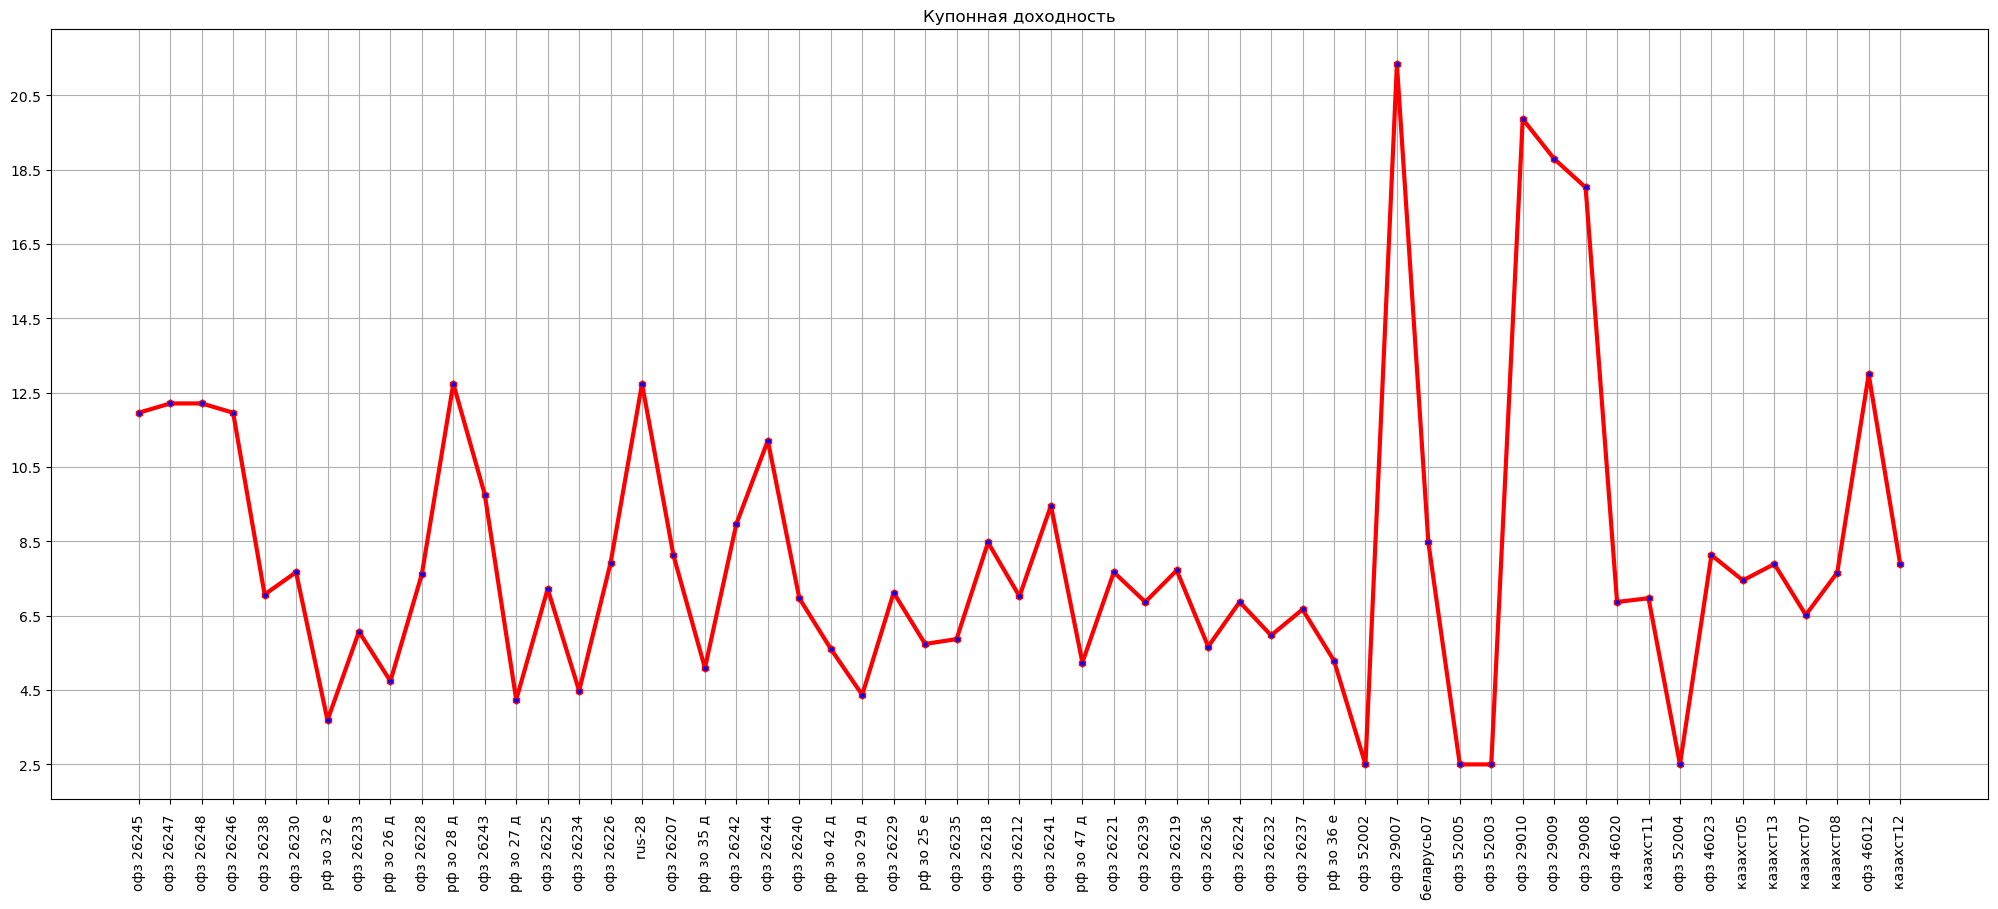

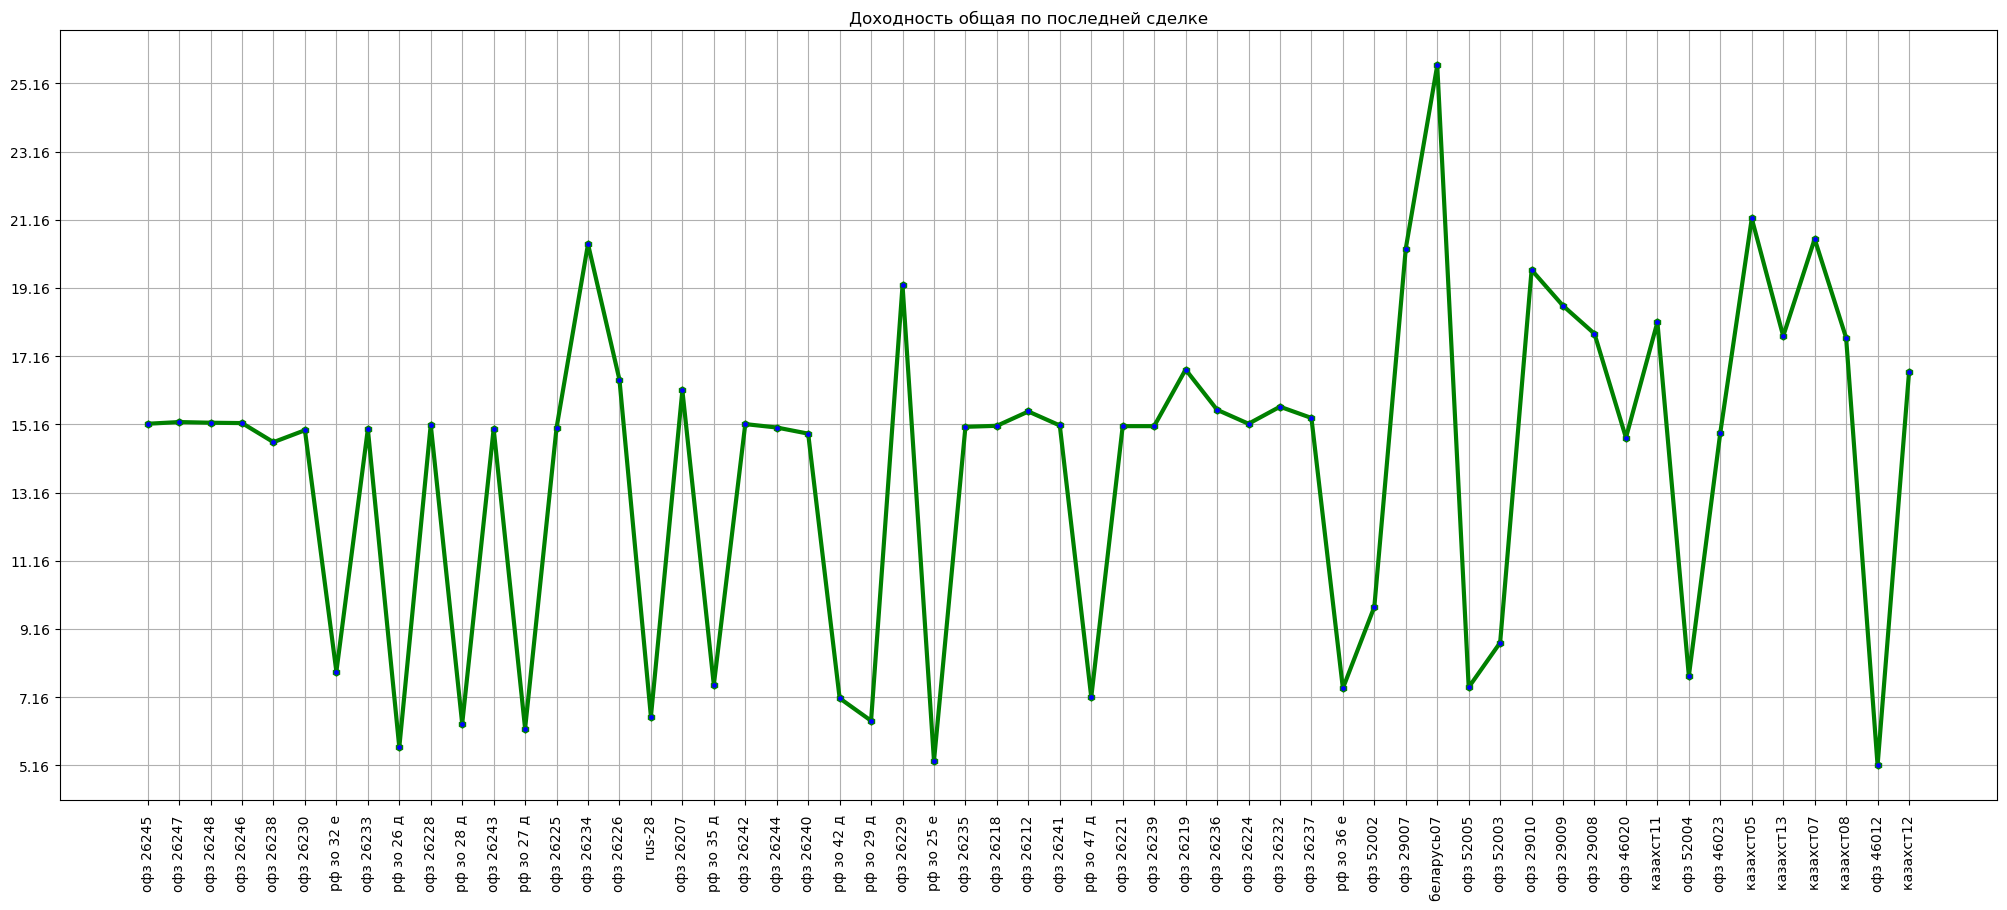

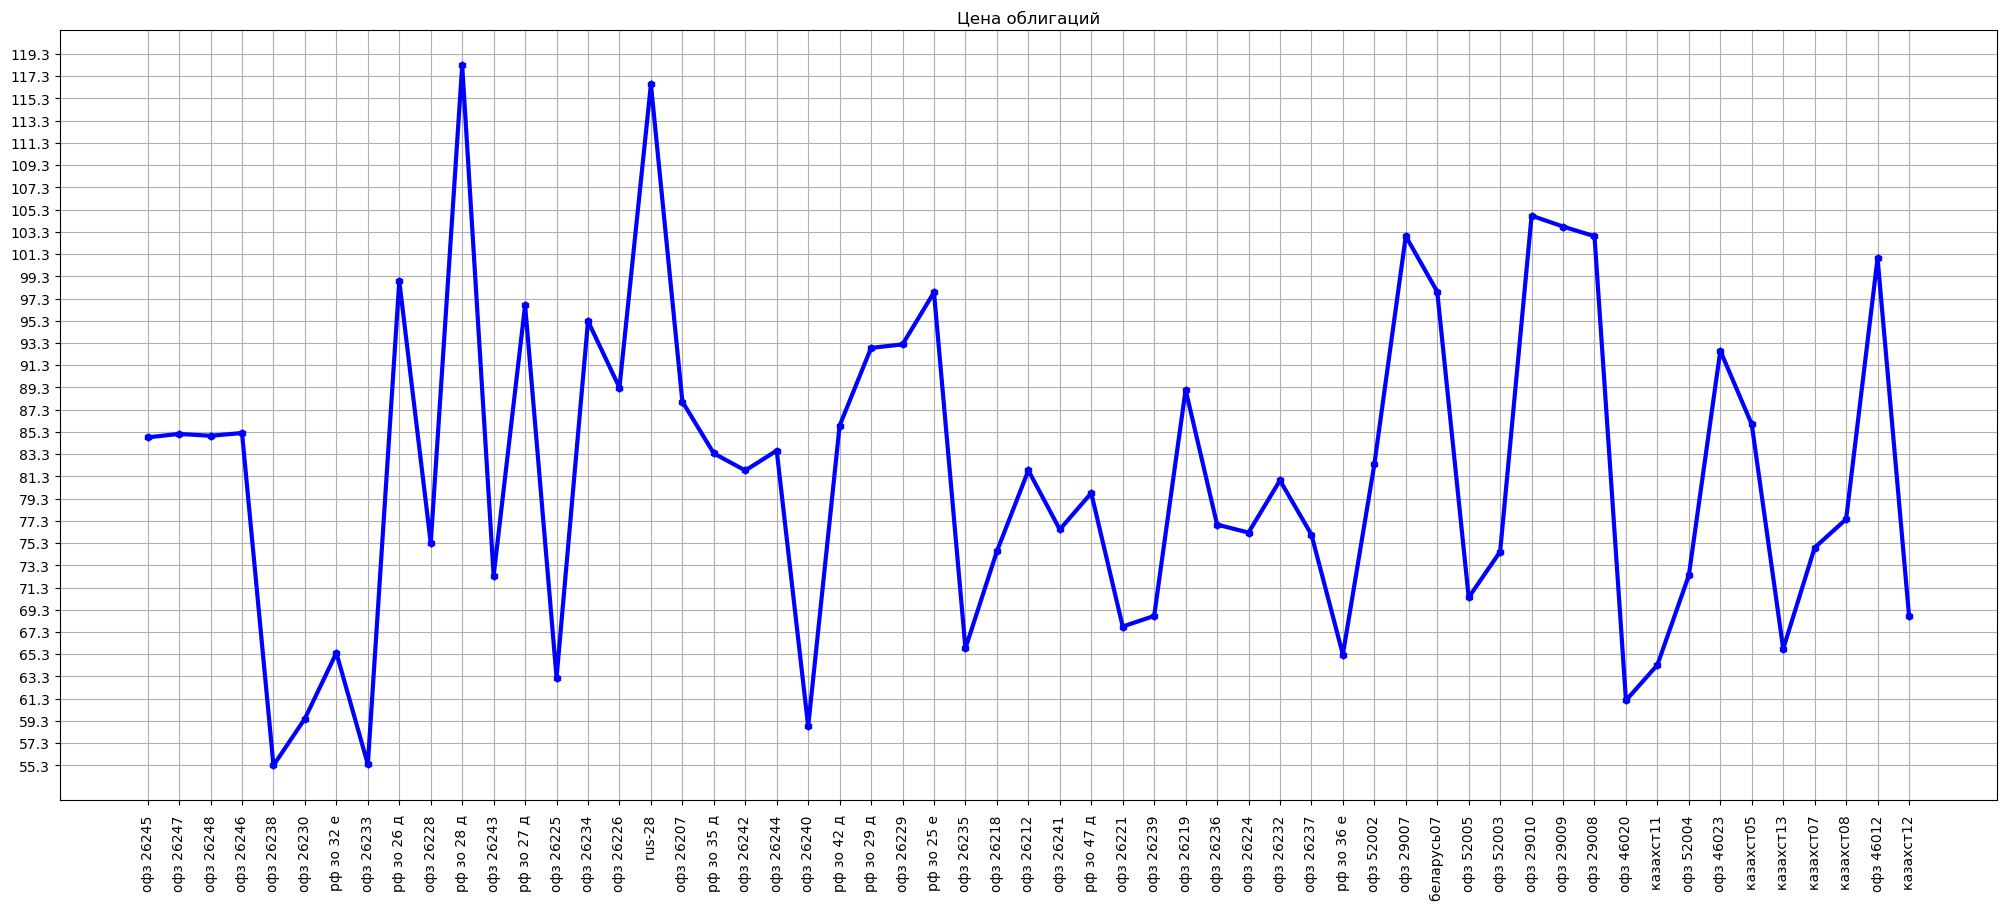

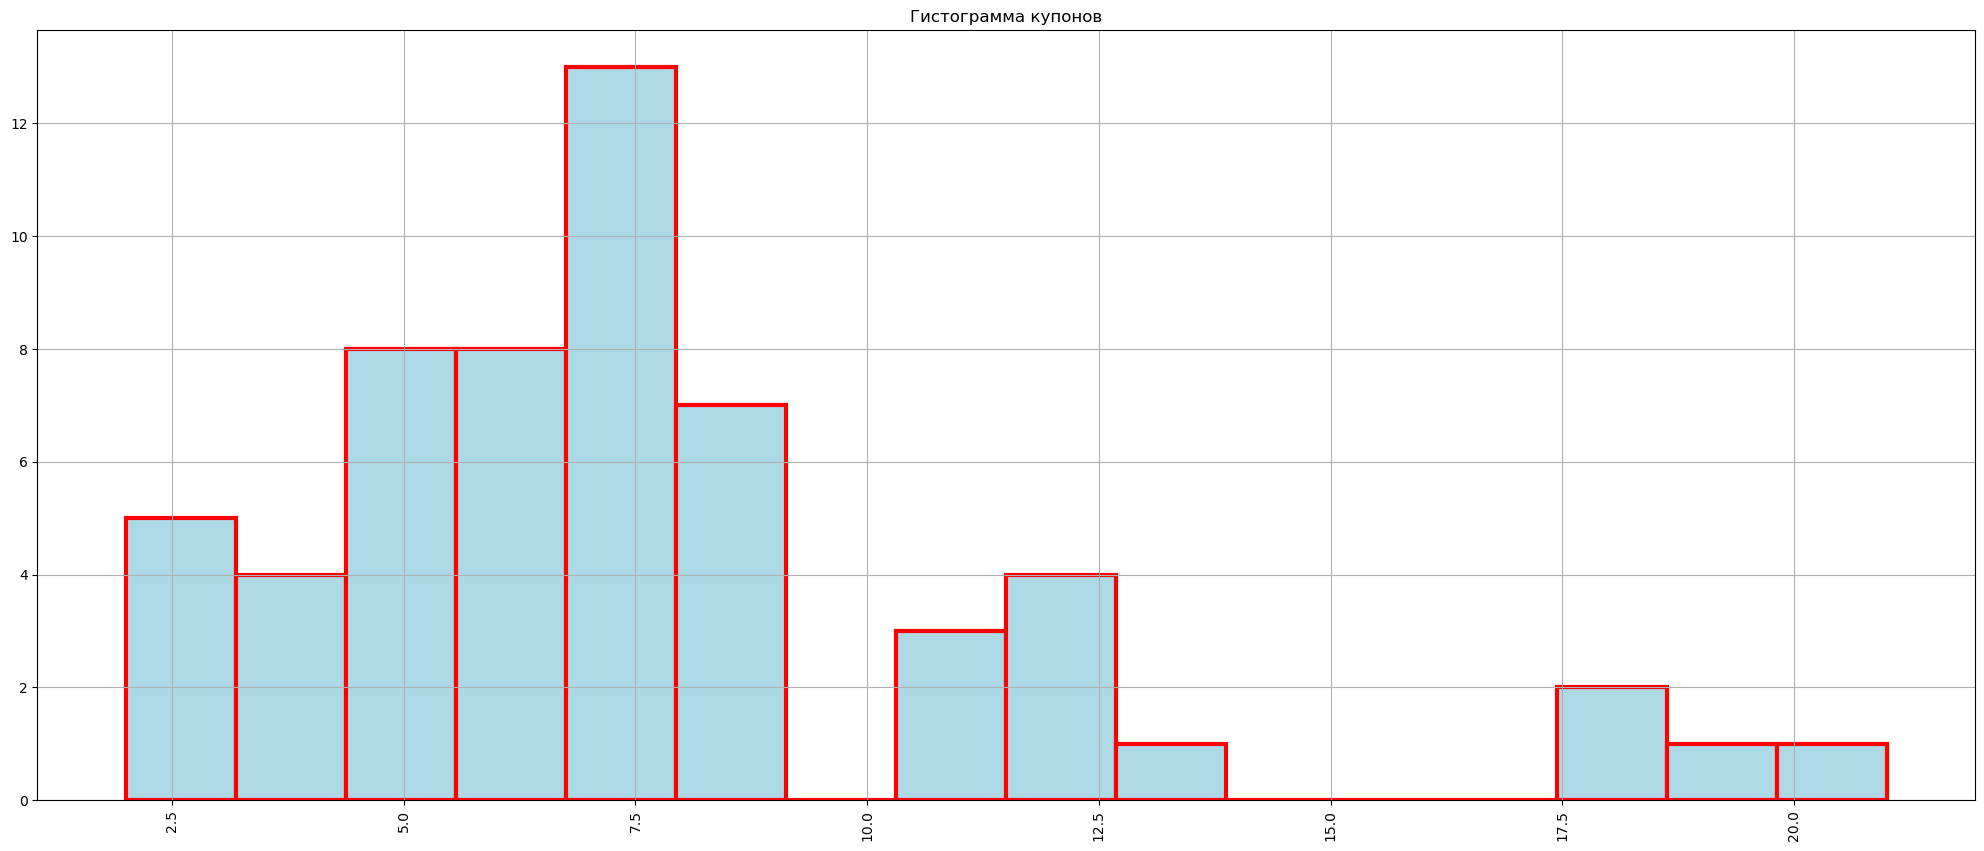

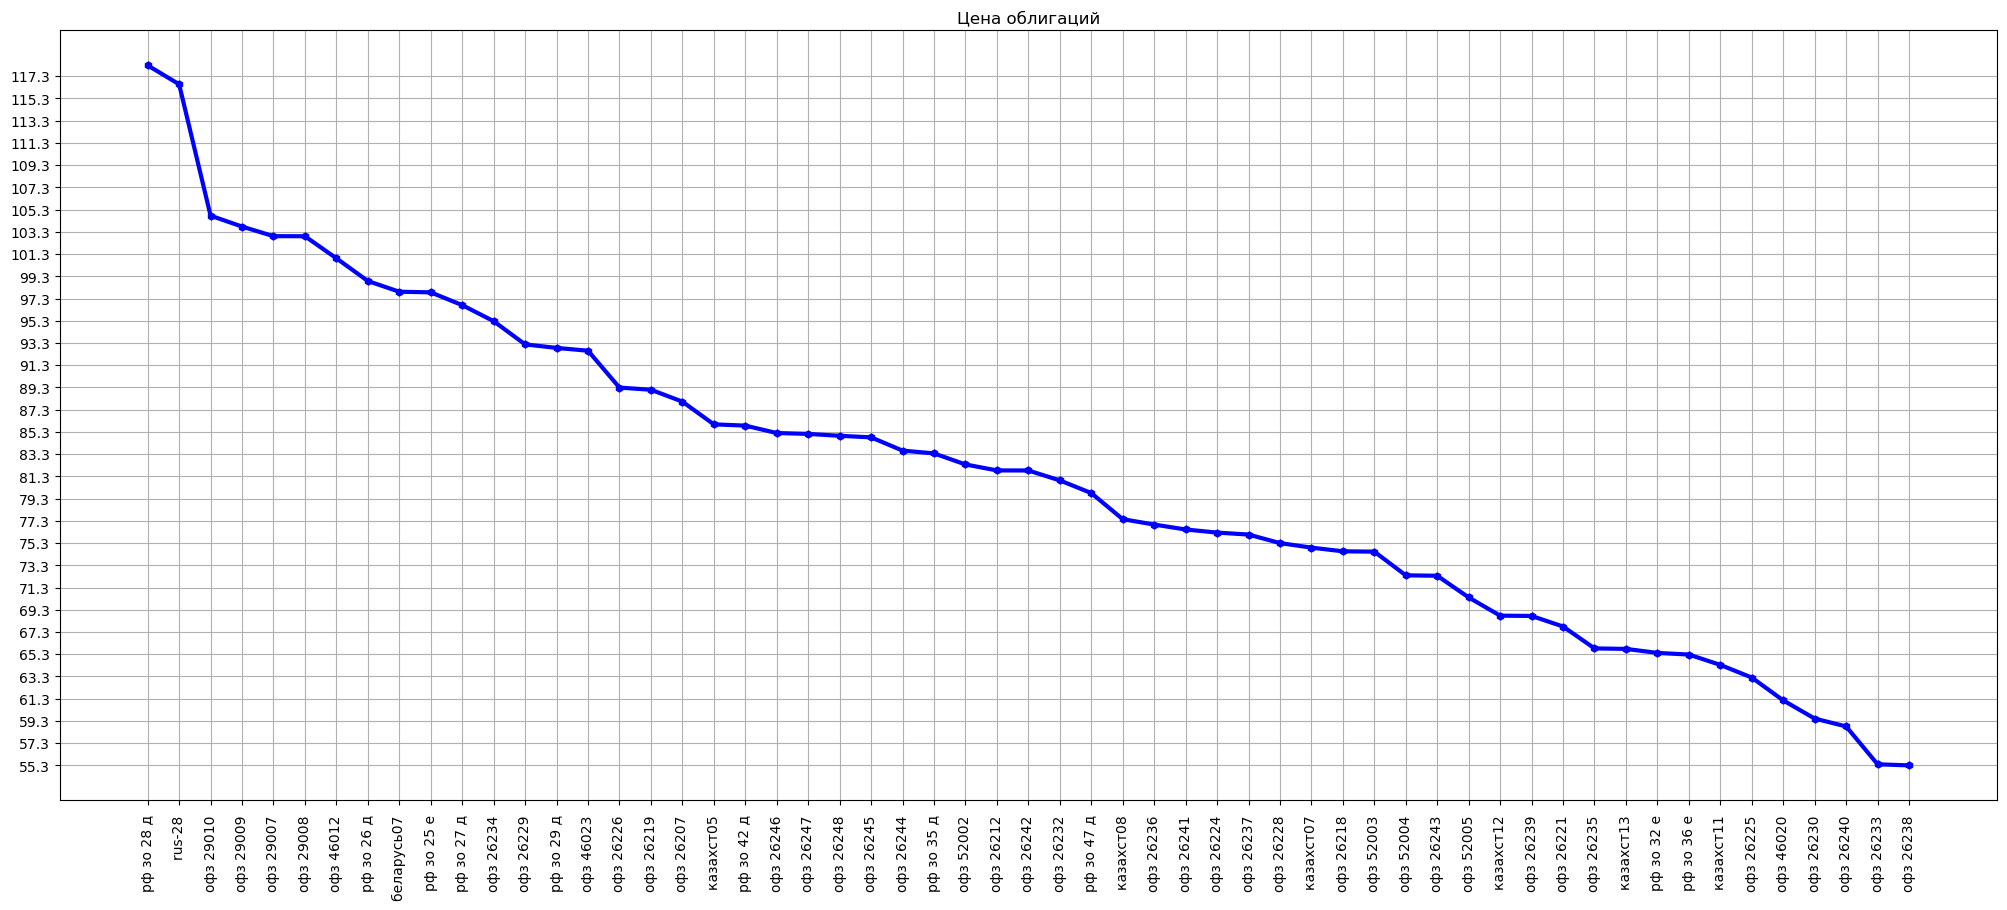

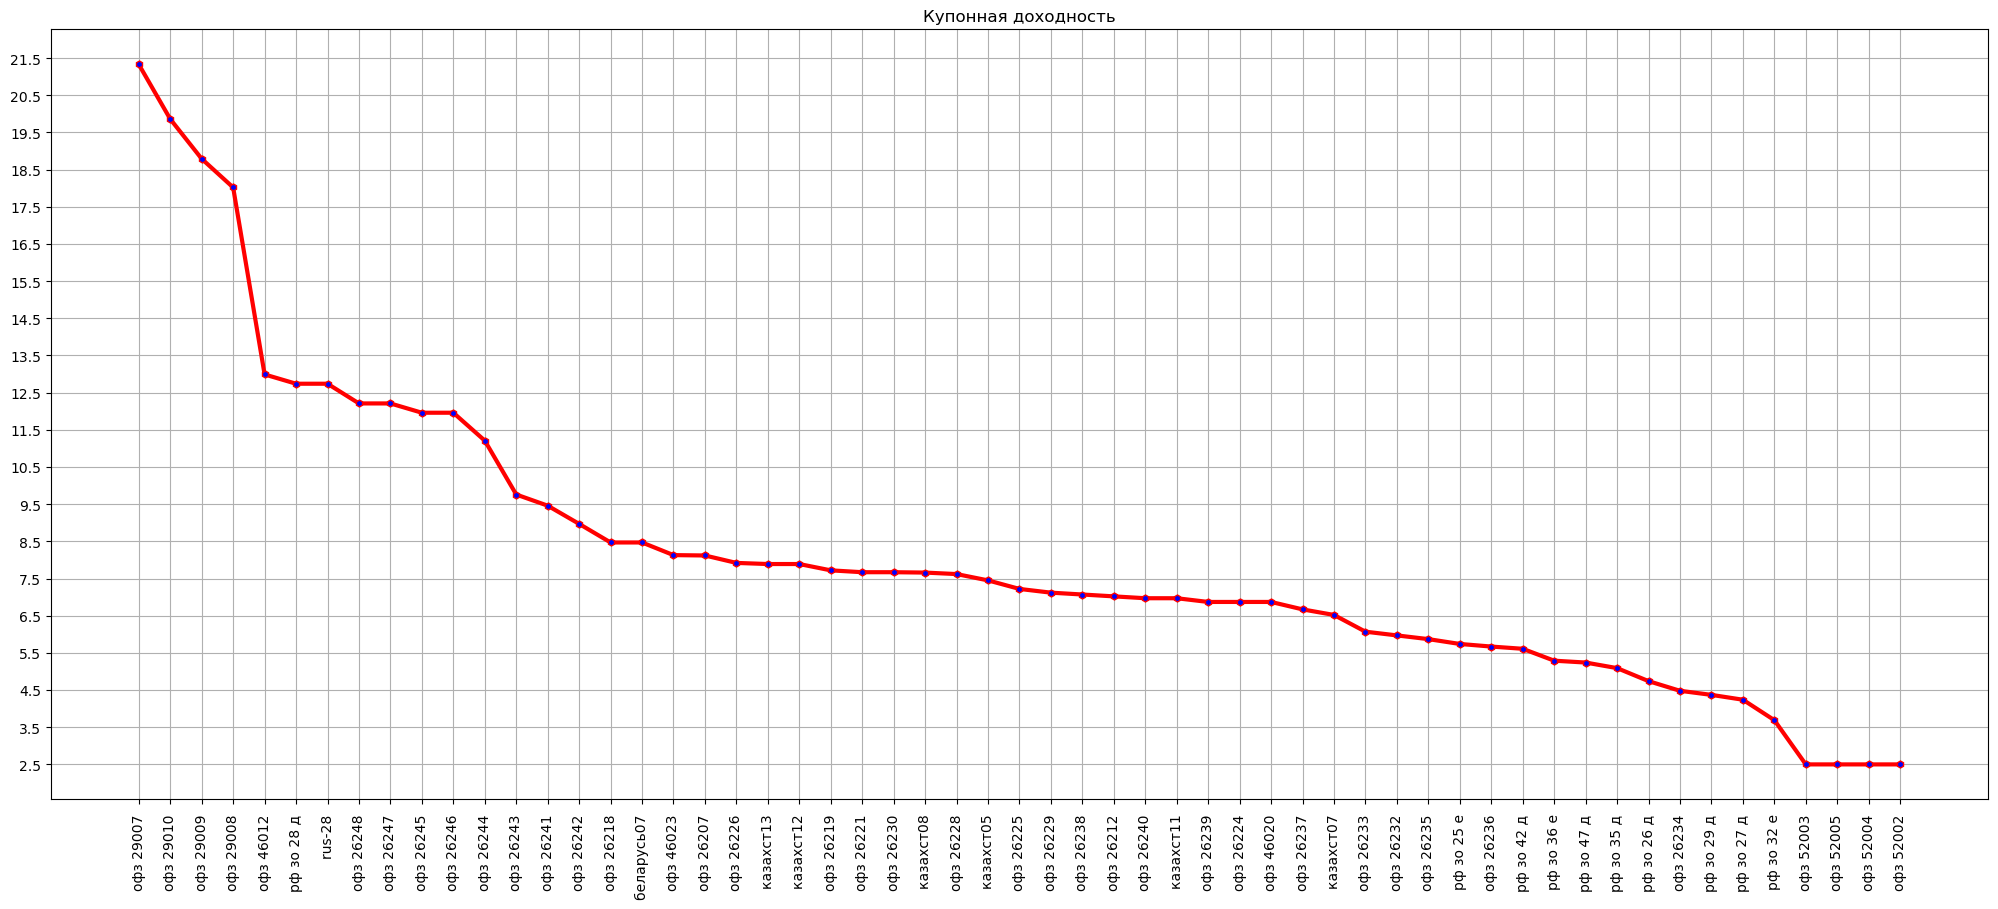

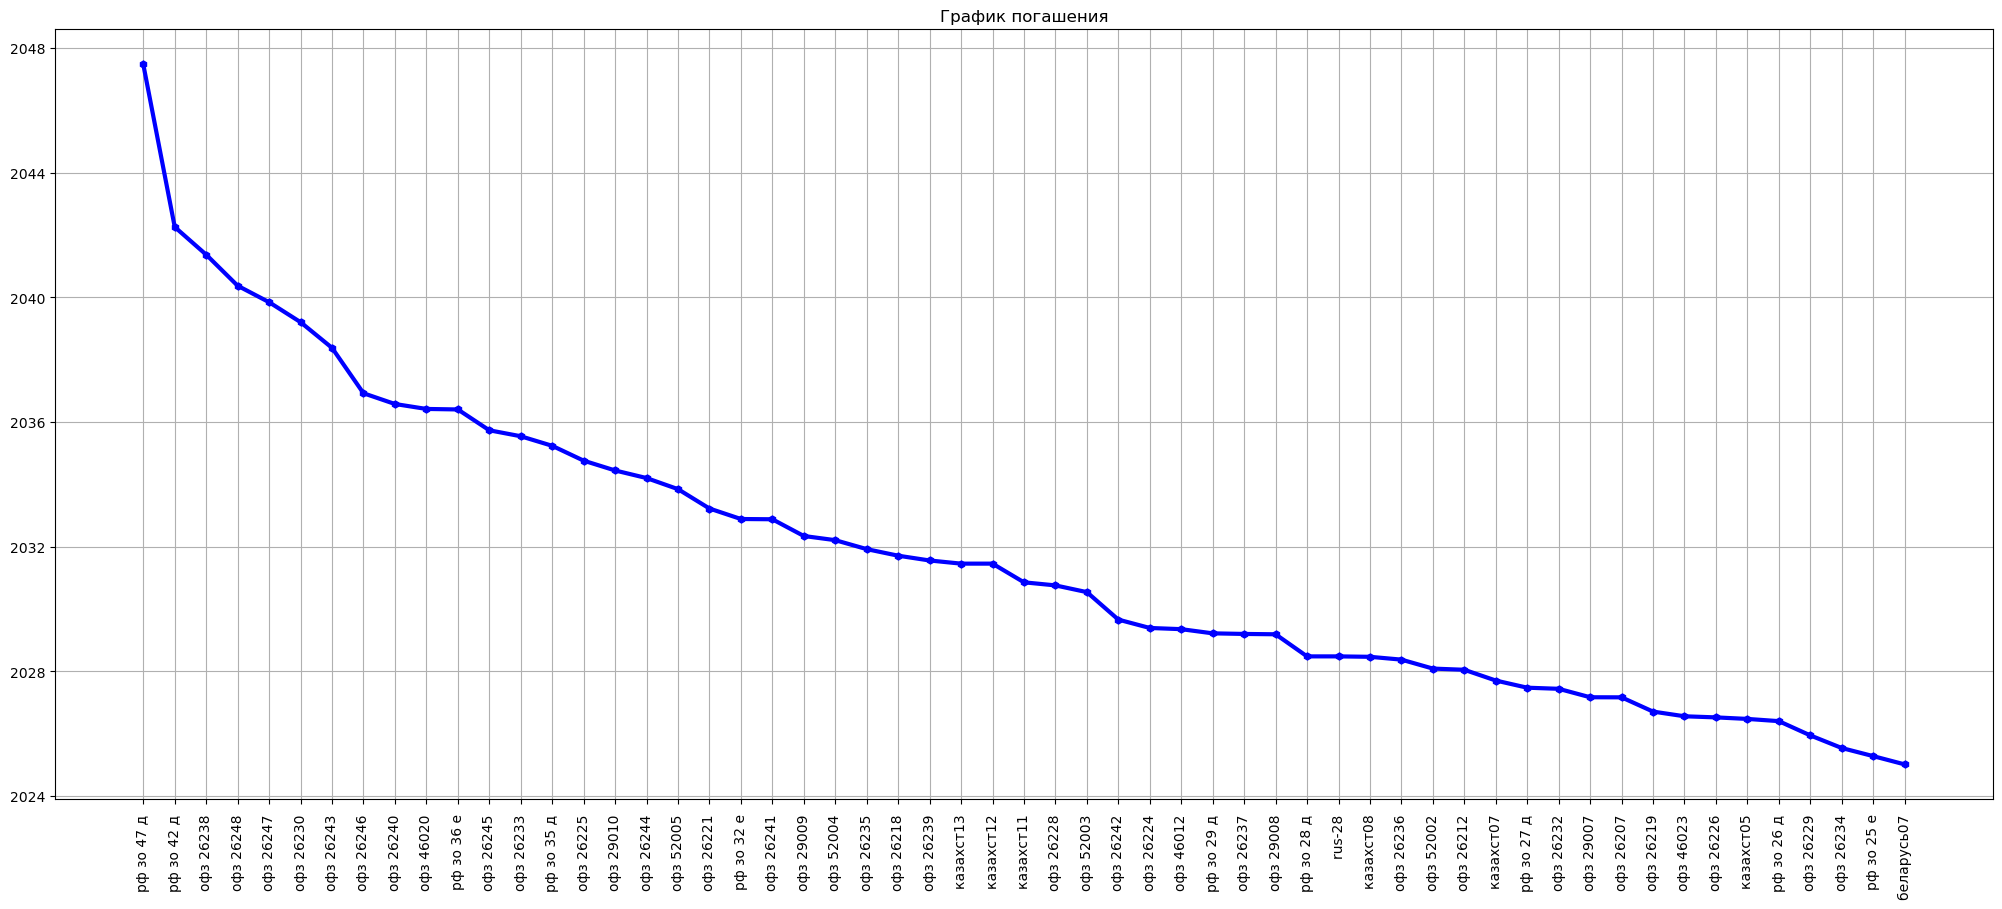

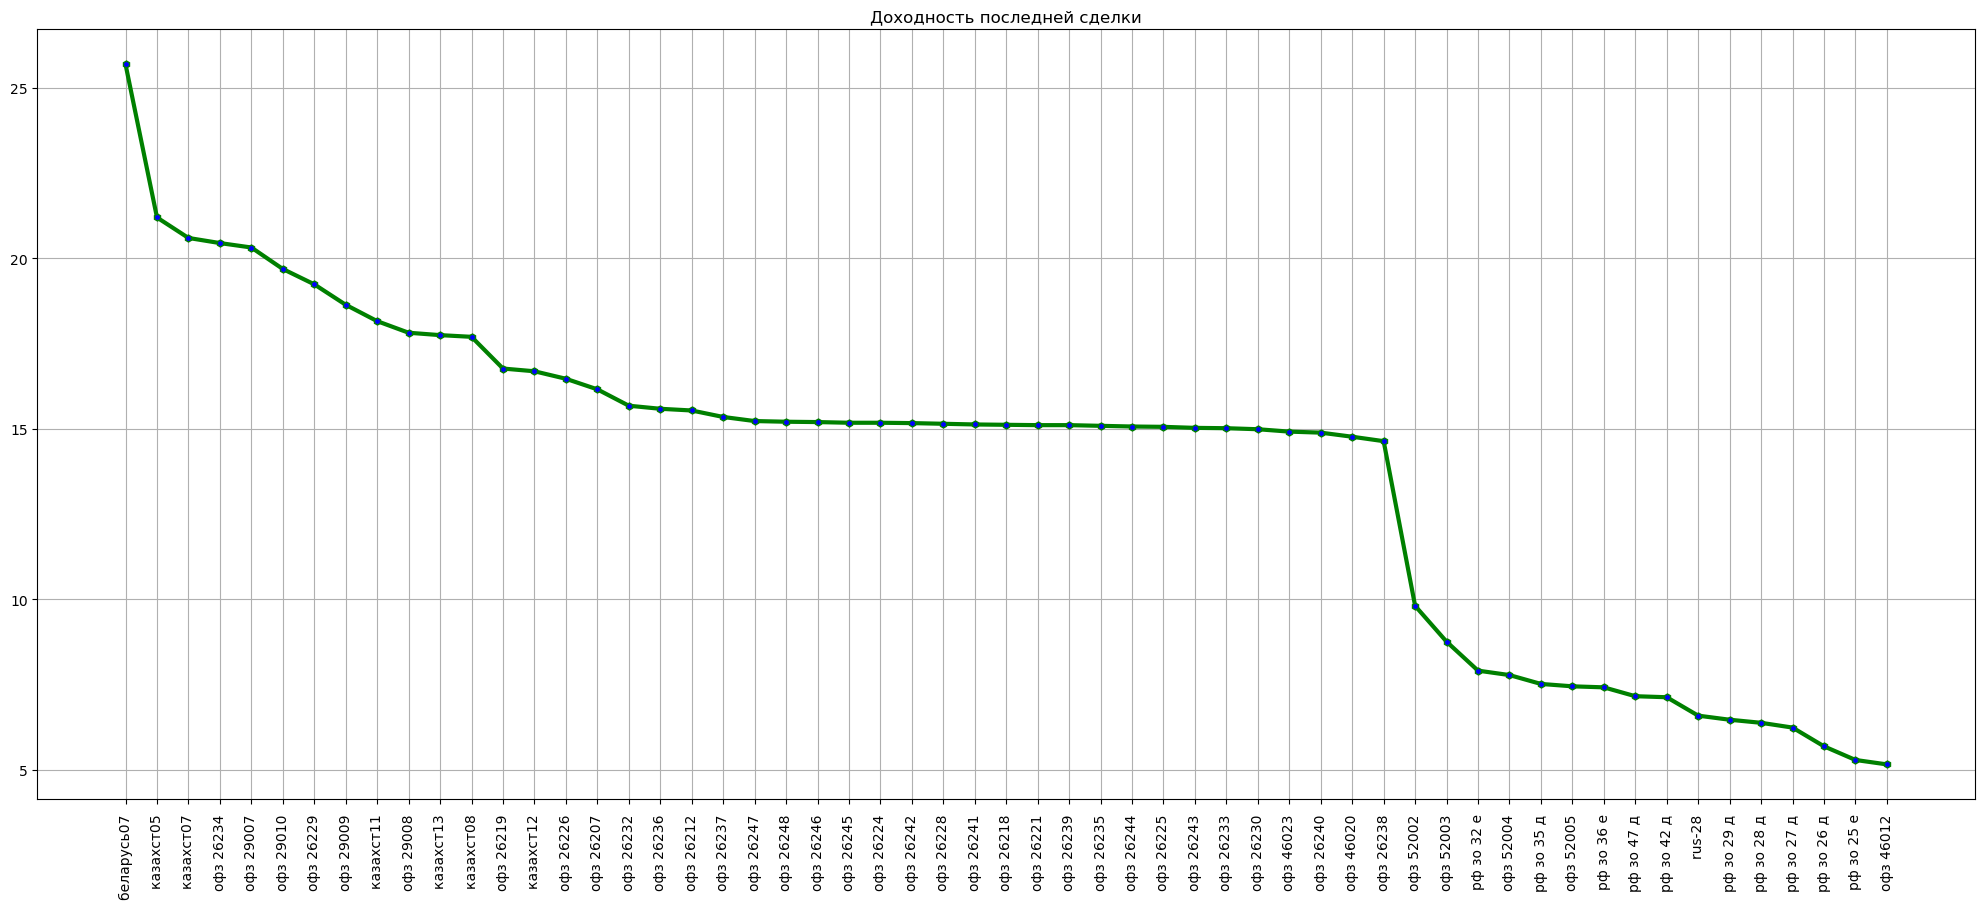

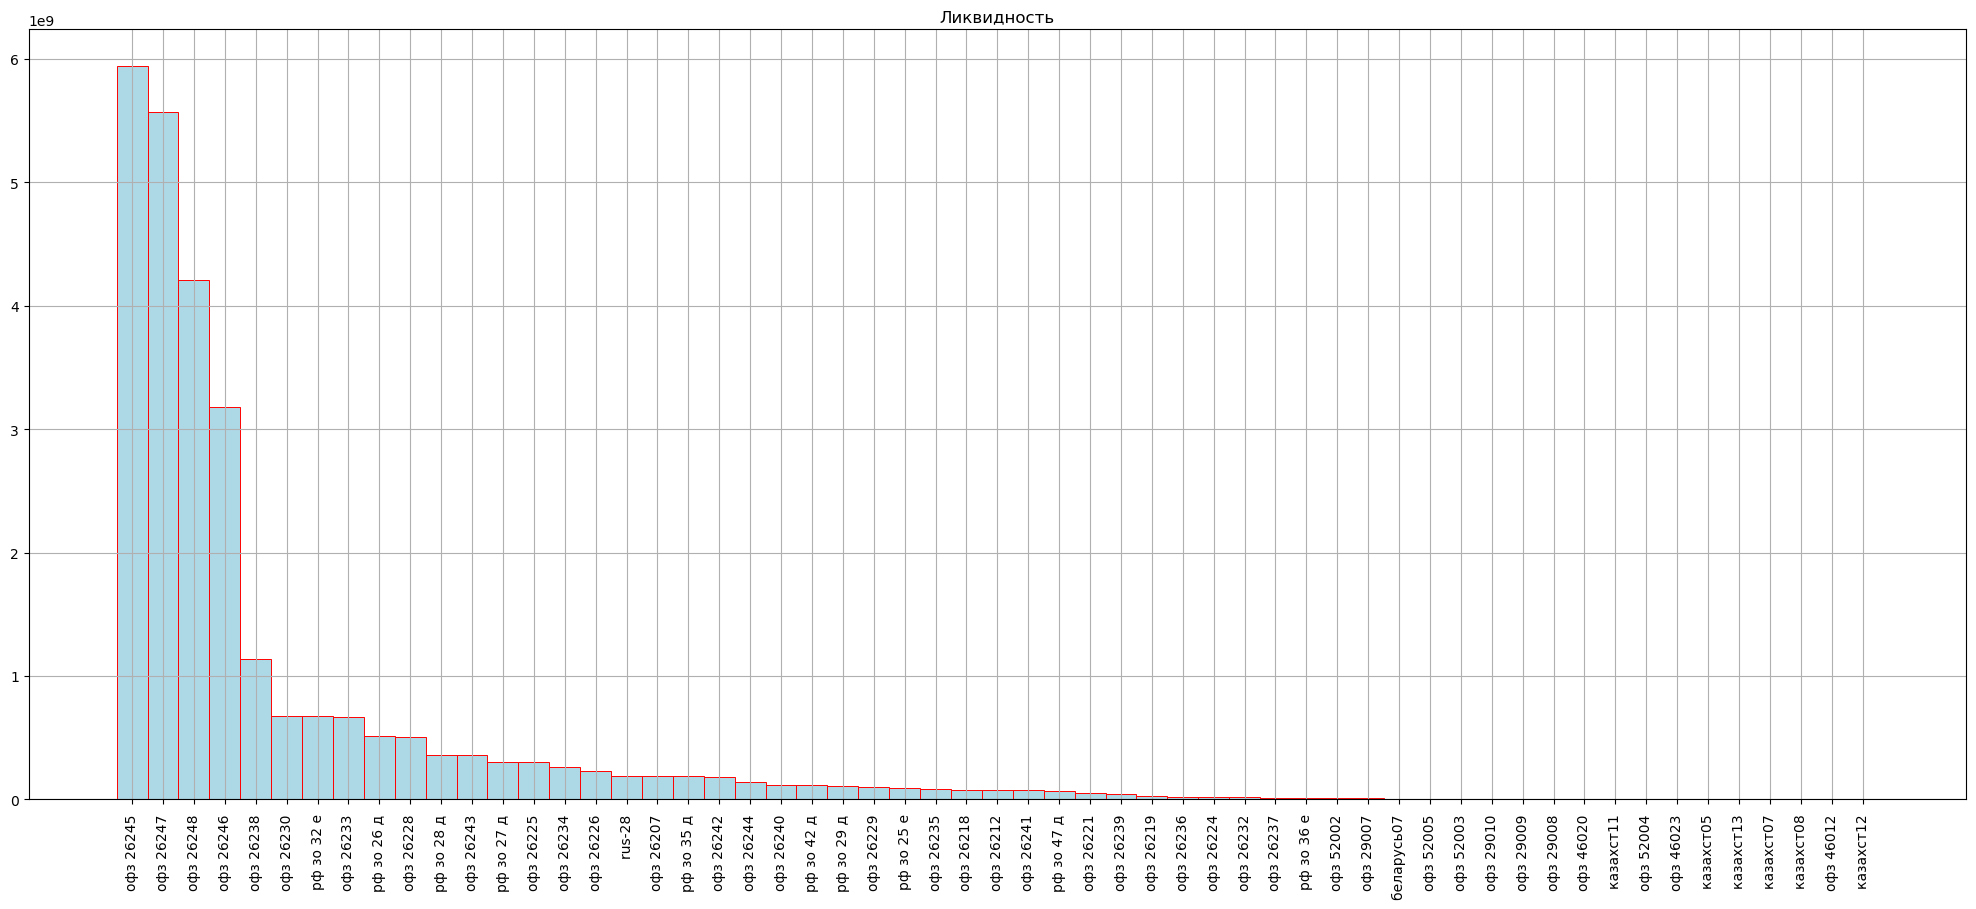

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import statistics
import csv
import generator_ofz as gen

data = pd.read_csv('ofz.csv', encoding='Windows-1251', decimal=',')
#названия столбцов в нижний формат, пробелы заменяем _, точки заменяем на пустой символ
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '')

#приводим к удобному формату:
#переводим в нижний формат
data['код'] = data['код'].str.lower()
data['наименование'] = data['наименование'].str.lower()
data['валюта_номинала'] = data['валюта_номинала'].str.lower()
data['валюта_расчетов'] = data['валюта_расчетов'].str.lower()

#некоторые значения суммы купона в сырых данных пропущены, заменяем на 0
data['сумма_купона'] = data['сумма_купона'].astype(str).str.replace('-', '0')
#приводим к float сумму купона, непогашенный долг, чтобы заполнить столбец ставка_купона
data['сумма_купона'] = data['сумма_купона'].str.replace(',', '.').astype(float)
data['непогашенный_долг'] = data['непогашенный_долг'].astype(float)
#заполняем столбец ставка_купона и переводим в проценты и в строку
data['ставка_купона'] = round(((data['сумма_купона'].astype(float) / data['непогашенный_долг'].astype(float) * 2) * 100), 2)

#убрали все бумаги, у которых нет рыночной цены
data['цена_%_средневзвешенная'] = data['цена_%_средневзвешенная'].astype(str).str.replace('-', '0')
data['цена_%_средневзвешенная'] = data['цена_%_средневзвешенная'].str.replace(',', '.').astype(float)
data = data.loc[data['цена_%_средневзвешенная'].astype(float) > 0]


#выводим очищенные данные в файлы и отрисовываем статистики на графиках
#дополнительно считаем статистики
###################################################################################
#убираем бумаги, у которых доходность последней сделки отрицательная или выше 2-х стандартных отклонений
#убираем бумаги, у которых средневзвешенная цена отрицательная или выше 2-х стандартных отклонений
data['дох_посл_сделки'] = data['дох_посл_сделки'].astype(str).str.replace('-', '0')
data['дох_посл_сделки'] = data['дох_посл_сделки'].str.replace(',', '.').astype(float)

stde_interest = statistics.stdev(data['ставка_купона'])
average_interest = statistics.mean(data['ставка_купона'])
stde_doh_last = statistics.stdev(data['дох_посл_сделки'])
average_doh_last = statistics.mean(data['дох_посл_сделки'])
stde_price = statistics.stdev(data['цена_%_средневзвешенная'])
average_price = statistics.mean(data['цена_%_средневзвешенная'])

data = data.loc[data['дох_посл_сделки'].astype(float) <= ((stde_doh_last * 2) + average_doh_last)]
data = data.loc[data['дох_посл_сделки'].astype(float) > 0]
data = data.loc[data['цена_%_средневзвешенная'].astype(float) <= ((stde_price * 2) + average_price)]
data = data.loc[data['цена_%_средневзвешенная'].astype(float) > 0]

stde_interest = statistics.stdev(data['ставка_купона'])
average_interest = statistics.mean(data['ставка_купона'])
stde_doh_last = statistics.stdev(data['дох_посл_сделки'])
average_doh_last = statistics.mean(data['дох_посл_сделки'])
stde_price = statistics.stdev(data['цена_%_средневзвешенная'])
average_price = statistics.mean(data['цена_%_средневзвешенная'])
sum_debt = data['объем_в_валюте'].astype(float).sum(axis = 0)

# дата посл сделки, средний купон, ст отклонение купона, средняя доха посл сделки, отклонение дохи посл сделки, 
# средняя цена, объем торгов в рублях
#print(data['дата_посл_сделки'])
with open('result_ofz.csv', 'a') as f:
    writer = csv.writer(f,  lineterminator='\n') 
    data_tmp = str(data['дата_посл_сделки'].values[:1])
    data_tmp = data_tmp[2:10]
    writer.writerow([data_tmp] + [str(round(average_interest, 2))] + [str(round(stde_interest, 2))] +
                   [str(round(average_doh_last, 2))] + [str(round(stde_doh_last, 2))] + [str(round(average_price, 2))] +
                   [str(round(stde_price, 2))] + [str(sum_debt)] )
# удаляем дубликаты в файле БД. для корректной работы нужен заголовок в файле  
data_tmp = pd.read_csv('result_ofz.csv', encoding='Windows-1251')
data_tmp = data_tmp.drop_duplicates()
data_tmp.to_csv('result_ofz.csv', index=False)

file_name = data['дата_посл_сделки'].values[:1].astype(str)
file_name = str(file_name)
file_name = file_name[2:10]

data.to_csv('result/site/' + file_name + 'ofz_cleared.csv', encoding='Windows-1251')
#отрисовываем график купонной доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['ставка_купона']), max(data['ставка_купона'])+2, 2.0))
ax.set_title("Купонная доходность")
ax.plot(data['наименование'],data['ставка_купона'], '-rh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'kupon_ofz.png')
#отрисовываем график общей доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['дох_посл_сделки']), max(data['дох_посл_сделки'])+2, 2.0))
ax.set_title("Доходность общая по последней сделке")
ax.plot(data['наименование'],data['дох_посл_сделки'], '-gh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'dohod_eff_ofz.png')
#отрисовываем график цен бумаг
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['цена_%_средневзвешенная']), max(data['цена_%_средневзвешенная'])+2, 2.0))
ax.set_title("Цена облигаций")
ax.plot(data['наименование'],data['цена_%_средневзвешенная'], '-bh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'price_ofz.png')

#отрисовываем частоту купонов
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
ax.set_title("Гистограмма купонов")
ax.hist(data['ставка_купона'].astype(int),16,linewidth = 3, color = "lightblue", ec="red")
ax.grid()
plt.savefig('result/site/' + file_name + 'interest_distribution_ofz.png')

#сортируем датасет по убыванию по столбцу цены
data_tmp = data.sort_values(by='цена_%_средневзвешенная', ascending=False)
#отрисовываем график цен бумаг по убыванию
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data_tmp['цена_%_средневзвешенная']), max(data_tmp['цена_%_средневзвешенная'])+1, 2.0))
ax.set_title("Цена облигаций")
ax.plot(data_tmp['наименование'],data_tmp['цена_%_средневзвешенная'], '-bh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'price_ofz_sorted.png')
#сортируем датасет по убыванию по столбцу купонной доходности
data_tmp = data.sort_values(by='ставка_купона', ascending=False)
#отрисовываем график отсортированной купонной доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data_tmp['ставка_купона']), max(data_tmp['ставка_купона'])+1, 1.0))
ax.set_title("Купонная доходность")
ax.plot(data_tmp['наименование'],data_tmp['ставка_купона'], '-rh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'kupon_ofz_sorted.png')

#сортируем датасет по убыванию даты погашения
data_tmp = data
data_tmp['дата_погашения'] = pd.to_datetime(data_tmp['дата_погашения'], format='mixed')
data_tmp = data.sort_values(by='дата_погашения', ascending=False)
#отрисовываем график отсортированной датой погашения
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
ax.set_title("График погашения")
ax.plot(data_tmp['наименование'],data_tmp['дата_погашения'], '-bh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'end_graphic_ofz.png')

#######################################################################
#сортируем датасет по убыванию доходность последней сделки
data_tmp = data
data_tmp = data.sort_values(by='дох_посл_сделки', ascending=False)
#отрисовываем график отсортированной датой погашения
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
ax.set_title("Доходность последней сделки")
ax.plot(data_tmp['наименование'],data_tmp['дох_посл_сделки'], '-gh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('result/site/' + file_name + 'dohod_eff_ofz_sorted.png')
#######################################################################
#сортируем датасет по убыванию по столбцу объем_в_валюте
data_tmp = data
data_tmp['объем_в_валюте'] = data_tmp['объем_в_валюте'].astype(float)
data_tmp = data.sort_values(by='объем_в_валюте', ascending=False)
#отрисовываем график отсортированной купонной доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
ax.set_title("Ликвидность")
ax.bar(data_tmp['наименование'], data_tmp['объем_в_валюте'], width=1, color = "lightblue", edgecolor="red", linewidth=0.7)
ax.grid()
plt.savefig('result/site/' + file_name + 'volume_ofz_sorted.png')


file_out = 'result/' + file_name + '.html'
gen.init(file_name, file_out)

rows = data.columns.tolist()
#gen.table(rows, file_out)

counter = 0
#код генерации общей таблицы всех бумаг не используется
'''while counter < len(data):
    data_tmp = data.iloc[counter]
    rows = data_tmp.values.tolist()
    gen.table(rows, file_out)
    counter+=1'''
gen.statistic_header(file_out)
rows = [str(round(average_interest, 2)) + "%", str(round(stde_interest,2))+ "%",str(round(average_doh_last,2))+ "%",
                                             str(round(stde_doh_last,2))+ "%", str(round(average_price,2))+ "%",str(round(stde_price,2))+ "%",
                                             str(round(sum_debt,2))]
gen.statistic_body(rows, file_out)
gen.graphics(file_out, file_name)

